# Preliminaries
We use the Palamedes Toolbox not only to for adaptive algorithms during data collection, but also to fit psychometric curves to the data as e.g. in Figure 3.

Prins, N & Kingdom, F. A. A. (2009) Palamedes:  Matlab routines for analyzing psychophysical data. http://www.palamedestoolbox.org 

Due to licence agreement, we cannot distibute the code alongside this repository. We used version 1.5.0 but more recent version should work as well. Once downloaded to your machine trom, add the function to the matlab path as well.

In [1]:
clear
% palamedespath = ['Path' filesep 'to' filesep 'Palamedes'];
% e.g.:
palamedespath = '/Users/treber/projects/matlab_common/palamedes1_5_0/Palamedes';
addpath(palamedespath)
outputdir = 'outputs';

Besides the code in these jupyter notebooks, there are some custom helper functions provided in this repository. These functions are stored in a folder named 'helperFunctions', which we need to add to the path:

In [2]:
addpath('helperFunctions')

### Load the output of `1_MATLAB_LoadAndAggregatedata.ipynb`

In [3]:
hfacorrection = 'regular';
%hfacorrection = 'snodgrass&corwin1988';
load([outputdir, filesep, 'sc_', hfacorrection, '.mat'])

# Figure 3
Figure 3 displays psychometric curves of data collapsed across all participants, but separate for each stimulus. 

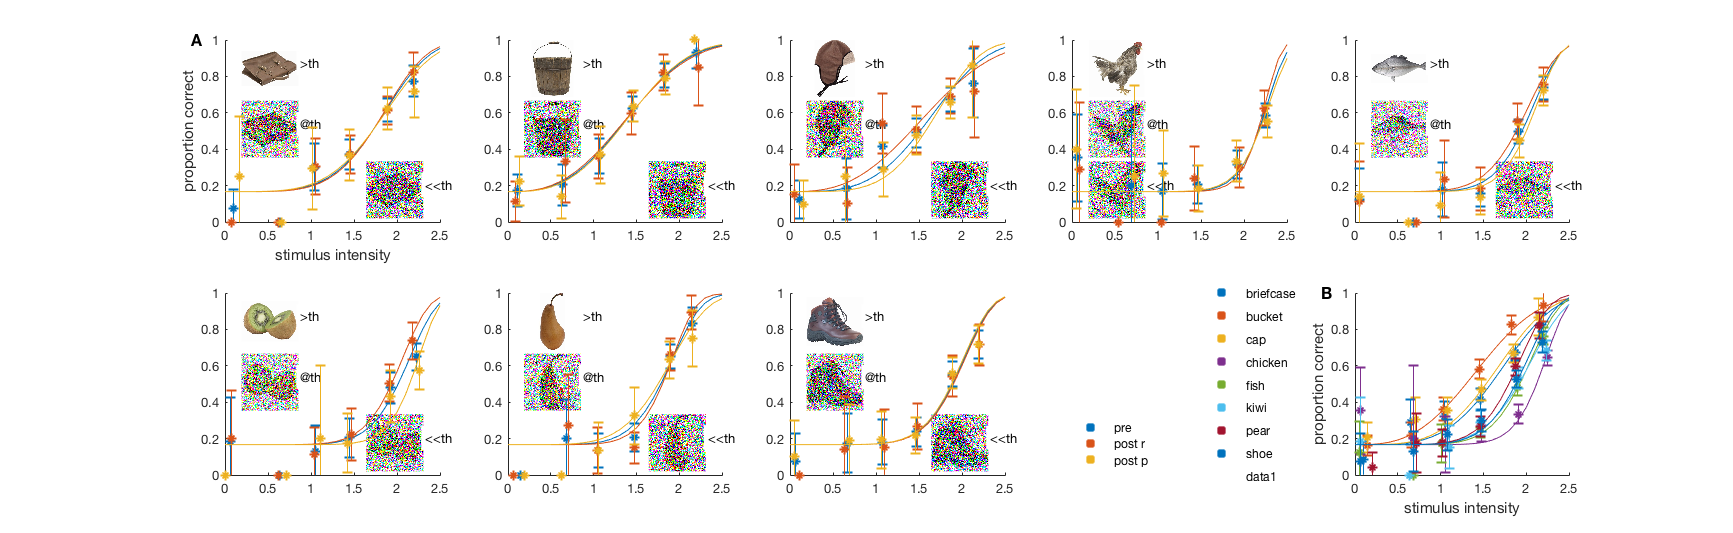

In [4]:
stim_path = ['paradigm' filesep 'octave' filesep 'stimuli' filesep];
stims = unique(th1.presented_stim_str);
do_labels = true;
do_bootstrap = false;
Nperms = 100;
Nbins = 6;

condiiton = unique(th1.th);

colors = [      0    0.4470    0.7410
    0.8500    0.3250    0.0980
    0.9290    0.6940    0.1250
    0.4940    0.1840    0.5560
    0.4660    0.6740    0.1880
    0.3010    0.7450    0.9330
    0.6350    0.0780    0.1840
    0         0.4470    0.7410];

fh = figure('Color','w', 'Position', [200 200 1300 400]);
set(fh, 'PaperPositionMode', 'auto');

for stim = 1:length(stims)
    % plot curve from per-th-estimation
    subplot(2,5,stim)    
    if stim > 1
        do_labels = false;
    end
        
    % plot stimuli at corresponding noise levels
    ax1 = gca;
    position = get(ax1,'Position');
    ax2 = axes('Position', position, 'color','none');
    
    if strcmp(stims{stim}, 'chicken')
        locations = [0 680; 0 340; 0 0];
    else        
        locations = [700 680; 0 340; 0 0];
    end

    thlevels = [0 1 2];
    thlabels = {'<<th', '@th', '>th'};
    for k = 1:3
        im = imread([stim_path, stims{stim}, '.jpg']);
        is = find(th1.th == thlevels(k) & strcmp(th1.presented_stim_str, stims{stim}));
        x_ = mean(th1.intensity(is));
        im = make_noise_image(im, 0, 2.5-x_);        
        subimage(locations(k,1),locations(k,2),im);
        hold on
        text(locations(k,1) + 330, locations(k,2)+130, thlabels{k}, ...
             'BackgroundColor', 'w');
    end
    axis([0 1020 0 1020])
    set(ax2, 'color', 'none');
    axis off
    hold on
    
    % plot th1 psychometric curce
    axes(ax1);
    set(ax1, 'color', 'none')
    is = strcmp(stims{stim}, th1.presented_stim_str);
    StimLevels = th1.intensity(is)';
    NumPos = th1.correct(is)';
    condition = th1.th(is)';
    OutOfNum =ones(1,length(condition));

    [h(1) xs_ alpha_ beta_] = psychometric_curve(StimLevels,NumPos,OutOfNum,condition, ...
                                 colors(1,:), do_labels, ...
                              do_bootstrap, Nbins, Nperms);
    axis([0 2.5 0 1]);
    hold on
    
    alphas_pre(stim) = alpha_;
    betas_pre(stim) = beta_;
    
    % plot curves from post-th test separate for rewarding and
    % punishing
    correct_r = [];
    intensity_r = [];
    correct_p = [];
    intensity_p = [];
    
    for r = 2:4
        correct_r = [correct_r perstim(stim,r).correct_r];
        correct_p = [correct_p perstim(stim,r).correct_p];
        intensity_r = [intensity_r perstim(stim,r).intensity_r];
        intensity_p = [intensity_p perstim(stim,r).intensity_p];        
    end
    
    StimLevels = intensity_r;
    NumPos = correct_r;
    OutOfNum = ones(1,length(correct_r));
    
    [h(2) xs_ alpha_ beta_] = psychometric_curve(StimLevels,NumPos,OutOfNum,[], ...
                              colors(2,:), do_labels, do_bootstrap, ...
                              Nbins, Nperms);
    hold on;
    
    alphas_r(stim) = alpha_;
    betas_r(stim) = beta_;
    
    StimLevels = intensity_p;
    NumPos = correct_p;
    OutOfNum = ones(1,length(correct_p));
    
    [h(3) xs_ alpha_ beta_] = psychometric_curve(StimLevels,NumPos,OutOfNum,[], ...
                              colors(3,:), do_labels, do_bootstrap, ...
                              Nbins, Nperms);
    
    
    alphas_p(stim) = alpha_;
    betas_p(stim) = beta_;
    
    xlim([0 2.5]);
    ylim([0 1]);

    if stim < 2
        text(-0.4, 1, 'A', 'FontWeight', 'bold', 'FontSize', 12);
    end
    
    set(ax1,'color', 'none')
end

% compare psychometric curves of all stimuli side by side
subplot(2,5,10)
stims = unique(th1.presented_stim_str); % across all subjects

% collapse across both threshold estimation procedures to do so
ths = {th1, th2};
for stim = 1:length(stims)
    
    StimLevels = [];
    NumPos = [];
    condition = [];
    OutOfNum = [];

    for i = 1:2
        is = strcmp(stims{stim}, ths{i}.presented_stim_str);
        StimLevels = [StimLevels; ths{i}.intensity(is)'];
        NumPos = [NumPos; ths{i}.correct(is)'];
        condition = [condition; ths{i}.th(is)'];
        OutOfNum = [OutOfNum; ones(1,length(condition))];        
    end
    h(stim) = psychometric_curve(StimLevels,NumPos,OutOfNum,condition, colors(stim,:));
end

xlim([0 2.5]);
ylim([0 1]);
text(-0.4, 1, 'B', 'FontWeight', 'bold', 'FontSize', 12);

% draw legends subplot
subplot(2,5,9)
clear h
ax1 = gca;
%colors = get(gca,'colororder');%distinguishable_colors(3,'w');
for i = 1:3
    h(i) = plot(1,1,'s', 'color', colors(i,:), 'MarkerFaceColor', colors(i,:));
    hold on
end
plot(1,1,'s', 'color', 'w',  'MarkerFaceColor', 'w')

pos1 = [0.59 0.12 0.1 0.1];
legend(h, {'pre', 'post r', 'post p'}, 'Position', pos1 );
legend('boxoff');
axis off
clear h

% draw legend with name of each stimulus
position = get(gca, 'Position');
ax2 = axes('Position', position);
%colors = distinguishable_colors(8, 'w');
for i = 1:8
    h(i) = plot(1,1,'s','color', colors(i,:), 'MarkerFaceColor', ...
                colors(i,:));
    hold on
end

pos2 = [0.67 0.08 0.1 0.4];
legend(h, stims, 'Position', pos2);
legend('boxoff');
plot(1,1,'s', 'color', 'w',  'MarkerFaceColor', 'w')

% draw separator
%plot([1 1], [0 1], '-k')
%set(gca, 'color', 'none');
axis off;

print(fh, [outputdir filesep 'figure3_' hfacorrection '.png'],  '-dpng' , '-r600')


# Figure 4
load the data generated by 1_MATLAB_LoadAndAggregateData.ipynb under section 4

In [5]:
load([outputdir filesep 'visibilityXreward' hfacorrection '.mat']);
nsubs = size(p_go, 1);
p_go_avg = squeeze(mean(p_go));
p_go_sem = squeeze(std(p_go)./sqrt(nsubs));

we uses Martina F. Callaghans barwitherr.m which can be downloaded from here: 

https://de.mathworks.com/matlabcentral/fileexchange/30639-barwitherr-errors-varargin-

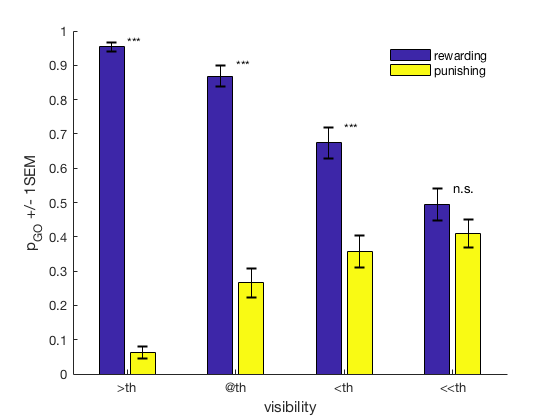

In [6]:
fh = figure('color', 'w');

barwitherr(p_go_sem, p_go_avg) 

box off;
ylabel('p_{GO} +/- 1SEM');
xlabel('visibility');
visibility_labels = {'>th','@th','<th','<<th'};
set(gca,'XTickLabel',visibility_labels);
legend_handle=legend('rewarding', 'punishing');
set(legend_handle, 'Box', 'off');

%% annotate post-hoc t-tests
for thl = 1:4
    [h, p, ci, stats] = ...
        ttest(squeeze(p_go(:,thl,1)), squeeze(p_go(:,thl,2))); 
    signlevel = 'n.s.';
    if p< 0.05
        signlevel = '*';
    end
    if p < 0.005
        signlevel = '**';
    end
    if  p < 0.001
        signlevel = '***';
    end
    
    indy = find(max(p_go_avg(thl,:)));
    y = p_go_avg(thl,indy)+p_go_sem(thl,indy); 
    text(thl,y,signlevel);    
end

print(fh, [outputdir filesep 'figure4_' hfacorrection '.png'],  '-dpng' , '-r600')

### ANOVA Stimulus Intensity X Condition using Matlab 

The ANOVA reported in the manuscript was computed using R. These analyses are documented in the jupyter notebook for R accomponying this document.

To compute the ANOVA with Matlab, we use the toolbox by Harald Hentschke (University of Tübingen) and Maik Stüttgen (University of Bochum), which is accompanied by a paper (Hentschke and Stüttgen, Eur J Neurosci 34:1887-1894, 2011).

https://github.com/hhentschke/measures-of-effect-size-toolbox

https://de.mathworks.com/matlabcentral/fileexchange/32398-hhentschke-measures-of-effect-size-toolbox

In [7]:
X = [conditioning.p_go', conditioning.run', ...
     conditioning.condition'];
X = sortrows(X,[2 3]); % data needs to be sorted for mes2way.m
AnovaTable= mes2way(X(:,1), X(:,2:3), {'partialeta2'}, 'isDep', [1 1], 'fName', ...
        {'run', 'condition'});

Display the overall proportion of Go responses:

In [8]:
mpgo = mean(p_go_avg,2)*100;
for i = 1:4
    disp(sprintf('run %d: %.0f%%', i, mpgo(i)));
end

run 1: 51%
run 2: 57%
run 3: 52%
run 4: 45%


# Figure 5

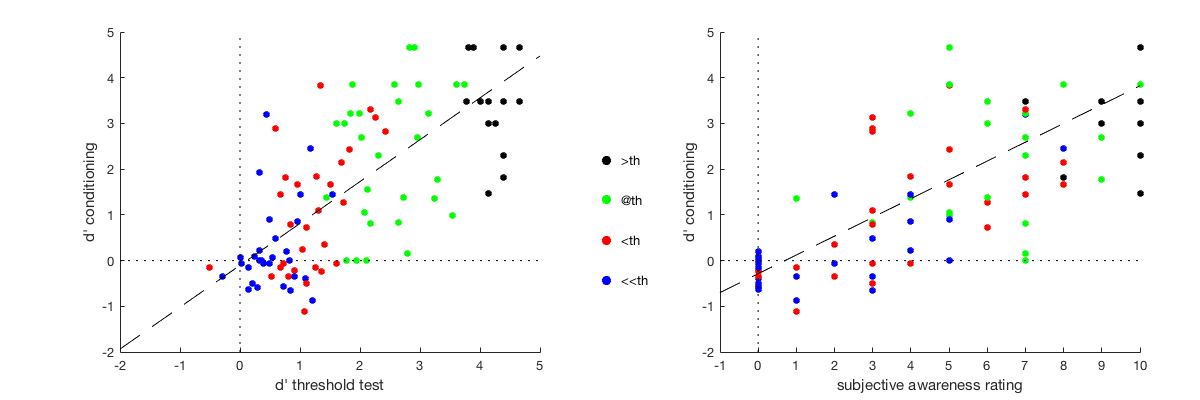

In [9]:
th_labels = {'<<th', '<th', '@th', '>th'};
th_colors = [0 0 1 ; 1 0 0 ; 0 1 0 ; 0 0 0];
fh = figure('Position', [200 200 900 300], 'Color', 'w');
set(gcf, 'PaperPositionMode', 'auto');

xlimits = [-2 5];
ylimits = [-2 5];

subplot('Position' , [0.1 0.12 0.35 0.8]);
plot_regression_si(dprime_post_av, dprime_conditioning, xlimits, ...
                   ylimits, visibility, th_colors);
xlabel('d'' threshold test');
ylabel('d'' conditioning');
subplot('Position' , [0.6 0.12 0.35 0.8]);
xlimits = [-1 10];
plot_regression_si(subjective_awareness, dprime_conditioning, xlimits, ...
                   ylimits, visibility, th_colors);
xlabel('subjective awareness rating');
ylabel('d'' conditioning');

subplot('Position' , [0.48 0.3 0.05 0.3]);
x = 1;
y = [1 2 3 4];

for i = 1:4
    plot(x, y(i), 'o', 'Color', th_colors(i,:), ...
             'MarkerFaceColor', th_colors(i,:), ...
             'MarkerSize', 6);
    hold on
    text(x + 0.5, y(i), th_labels{i});   
end
axis off

print(fh, [outputdir filesep 'figure5_' hfacorrection '.png'],  '-dpng' , '-r600');
print(fh, [outputdir filesep 'figure5_' hfacorrection '.eps'],  '-depsc');

# Figures 6 & 7

These figures are very similar in that they both plot regression for each subject. Figure 6 uses the objective threshold test performance as predictor, whereas figure 7 uses the subjective awareness rating:

In [10]:
% figure 6 configuration
vars{1}.values = dprime_post_av;
vars{1}.name = 'd'' threshold test';
vars{1}.fn = 'regressions_ss_obj';
vars{1}.limits = [-2 5];
vars{1}.ylimits = [-5 5];
vars{1}.dependent = dprime_conditioning;
vars{1}.ylabel = 'd'' conditioning';

% figure 7 configuration
vars{2}.values = subjective_awareness;
vars{2}.name = 'subjective awareness rating';
vars{2}.fn = 'regressions_ss_subj';
vars{2}.limits = [-1 10];
vars{2}.ylimits = [-5 5];
vars{2}.dependent = dprime_conditioning;
vars{2}.ylabel = 'd'' conditioning';

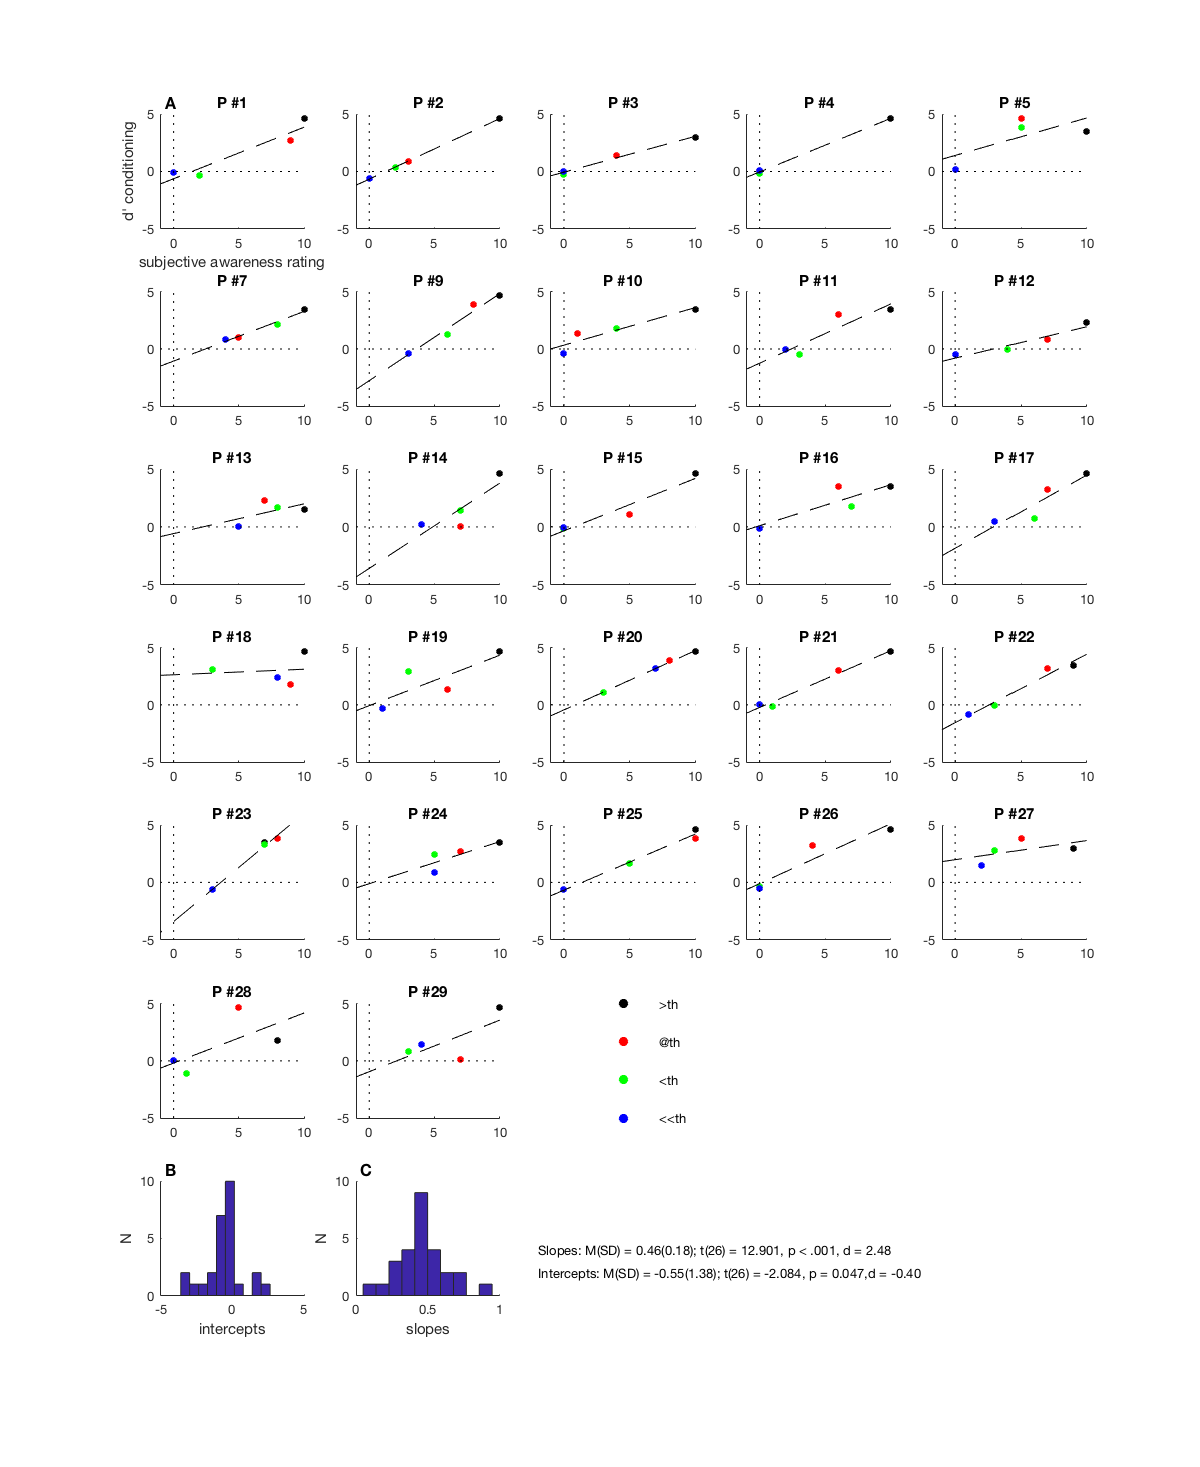

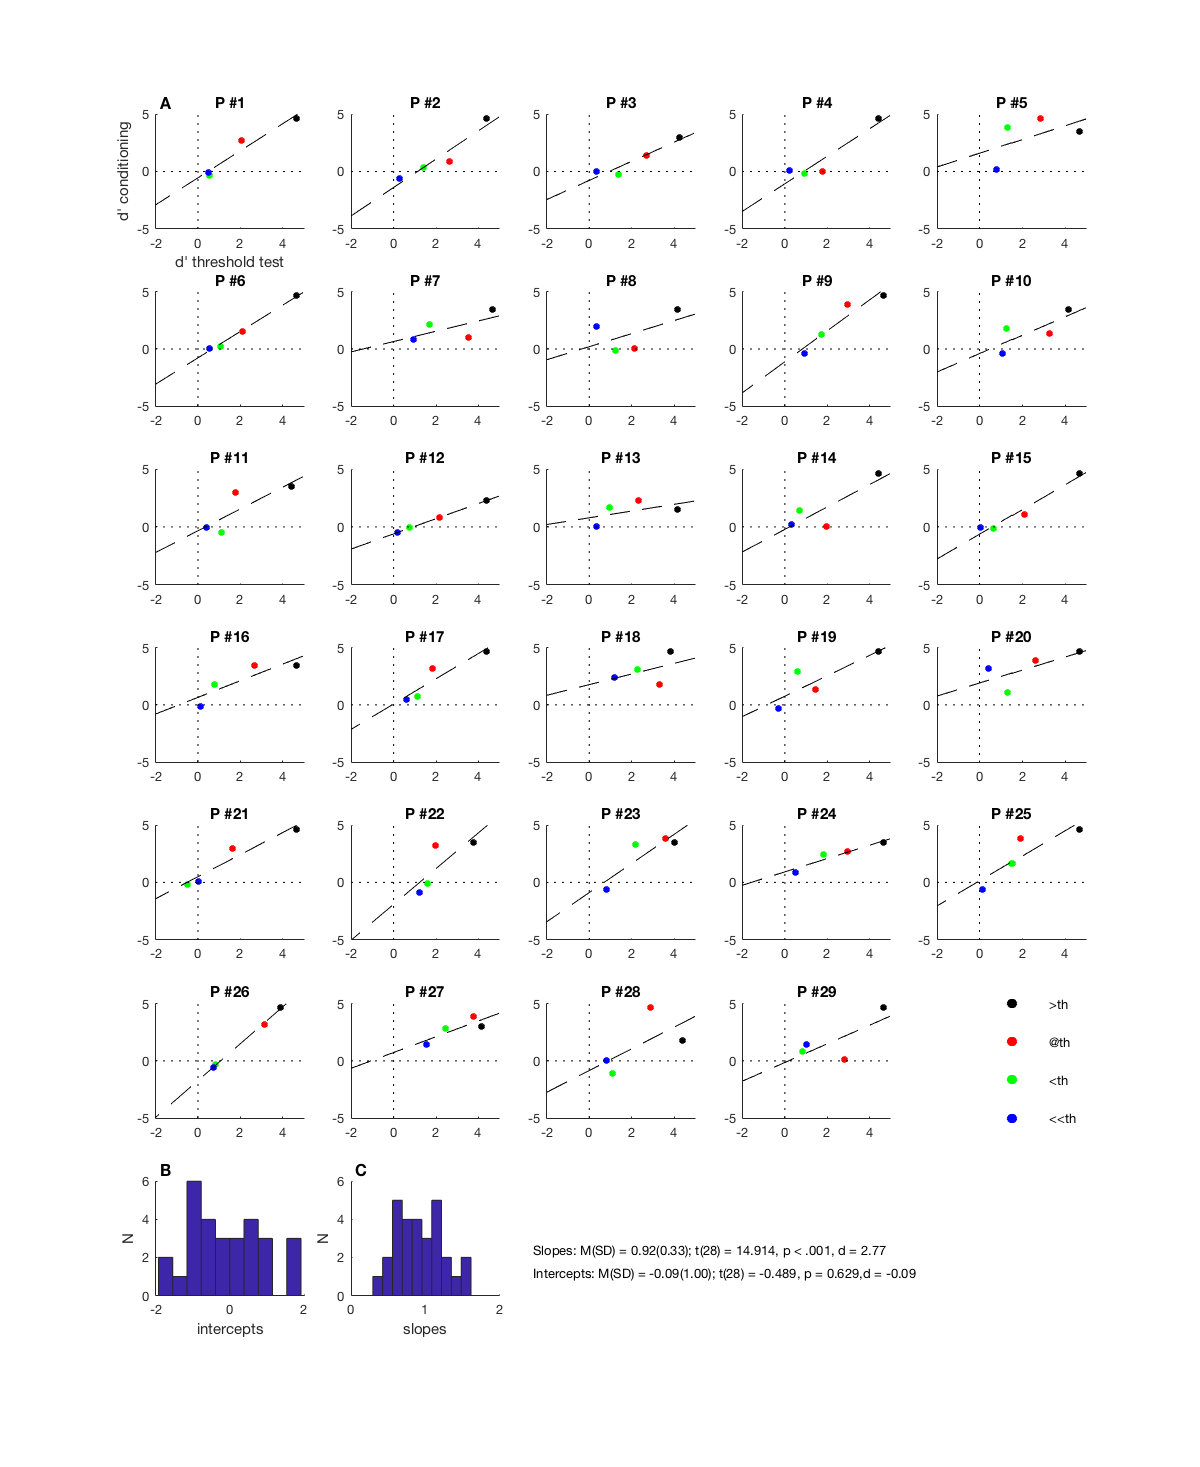

In [11]:
for f = 1:2
    fh = figure('Position', [200 200 900 1100], 'Color', 'w');
    set(gcf, 'PaperPositionMode', 'auto');

    xlimits = vars{f}.limits;

    if isfield (vars{f}, 'ylimits')
        ylimits = vars{f}.ylimits;
    else
        ylimits = [];
    end

    colors  = [0 0 1 ; 0 1 0 ; 1 0 0 ; 0 0 0];
    subpl = 1;

    for i = 1:length(unique(S))
        if max(isnan(vars{f}.values(S==i))) > 0 | ...
                length(find(isnan(vars{f}.dependent(S==i)))) > 1
            
            slopes(i) = NaN;
            intercepts(i) = NaN;
            i = i + 1;
        else

            subplot(7,5,subpl)
            [intercepts(i) slopes(i)] = plot_regression_si(vars{f}.values(S==i), ...
                                                           vars{f}.dependent(S==i), xlimits, ylimits, ...
                                                           visibility(S==i), colors, false);

            if i == 1
                y_ = ylim;        
                text(vars{f}.limits(1), y_(2)+(y_(2) - y_(1)) / 10, '\bf A', 'FontSize', 12); 
                xlabel(vars{f}.name)
                ylabel(vars{f}.ylabel)
            end
            title(sprintf('P #%d', i));
            subpl = subpl + 1;
        end
    end


    subplot(7,5,subpl)
    x = 1;
    y = [1 2 3 4];

    for i = 1:4
        plot(x, y(i), 'o', 'Color', colors(i,:), ...
             'MarkerFaceColor',  colors(i,:), ...
             'MarkerSize', 6);
        hold on
        text(x + 0.5, y(i), th_labels{i});
    end
    axis off

    subplot(7,5,31)
    
    intercepts = intercepts(~isnan(intercepts));
    slopes = slopes(~isnan(slopes));
    
    
    hist(intercepts);
    xlabel('intercepts');
    ylabel('N');
    box off
    y_ = ylim;        
    x_ = xlim;

    text(x_(1), y_(2)+(y_(2) - y_(1)) / 10, '\bf B', 'FontSize', 12); 
    ylim(y_);

    subplot(7,5,32);
    hist(slopes);
    xlabel('slopes');
    ylabel('N');
    box off
    y_ = ylim;        
    x_ = xlim;
    text(x_(1), y_(2)+(y_(2) - y_(1)) / 10, '\bf C', 'FontSize', 12); 
    ylim(y_);

    subplot(7,5,33);

    % runs stats on regression paramteres
    [h p ci stats] = ttest(intercepts);

    if p > 0.001
        p_str = sprintf('p = %.3f', p);
    else
        p_str = 'p < .001';
    end

    % cohens d
    %d = mean(intercepts)/std(intercepts);
    d = stats.tstat / sqrt(length(intercepts));

    intercept_stats_txt = sprintf(['Intercepts: M(SD) = %.2f(%.2f); t(%d) = ' ...
                        '%.3f, ', p_str, ',d = %.2f'], ...
                                  mean(intercepts), std(intercepts), stats.df, stats.tstat, ...
                                  d);

    [h p ci stats] = ttest(slopes);

    % cohens d
    d = mean(slopes)/std(slopes);
    d = stats.tstat / sqrt(length(slopes));


    if p > 0.001
        p_str = sprintf('p = %.3f', p);
    else
        p_str = 'p < .001';
    end

    slopes_stats_txt = sprintf(['Slopes: M(SD) = %.2f(%.2f); t(%d) = ' ...
                        '%.3f, ', p_str , ', d = %.2f'], ...
                               mean(slopes), std(slopes), stats.df, stats.tstat, ...
                               d);

    text(0,0, intercept_stats_txt);
    text(0,1, slopes_stats_txt);

    ylim([-1 4]);
    xlim([0.5 6]);
    axis off

    %print([outpath, vars{f}.fn, '.eps'],'-depsc');
    print(fh, sprintf('%s%sfigure%d_%s.png', outputdir, filesep, 5+f, hfacorrection),  '-dpng' , '-r600')
    clear slopes intercepts
end

# Response to Reviews
## Use Snodgrass & Corwin, 1988 to correct hit and false alarm rates for d' computation
A Reviewer ask to assess the consequences of using Snodgrass and Corwin 1988 to take care of hit and false alarm rates of either exactly zero or exactly 1.

To do so we changed the aggregate data functions and especially `sc_hits_fa.m`, and added to option to switch between snodgrass and corwin and our regular method to obtain hits and flase alarms in `1_MATLAB_LoadAndAggregateData.ipynb`. The resulting data were stored either as `sc_snodgrassMccorwin1988.mat` or `sc_regular.mat`. 

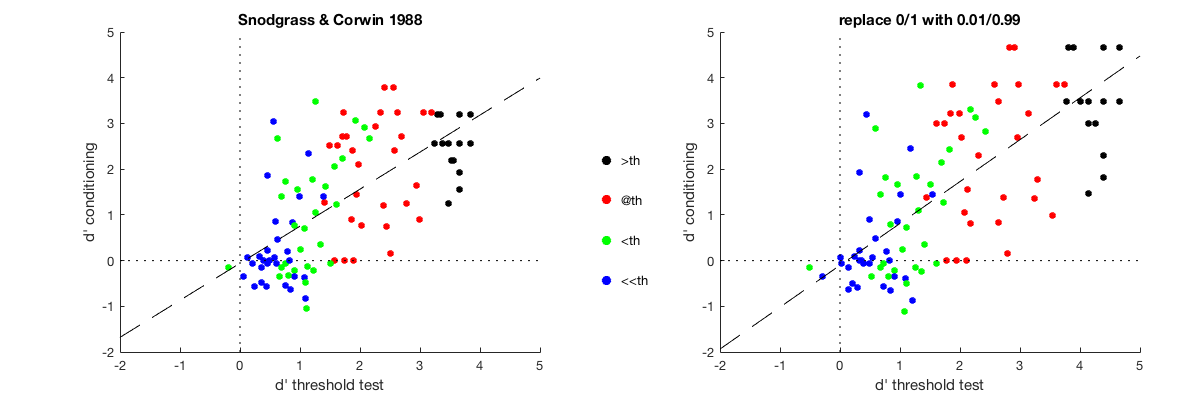

In [12]:
c = load([outputdir filesep 'sc_snodgrass&corwin1988.mat']); % add 0.5 to the numerator and 1 to the denominator
r = load([outputdir filesep 'sc_regular.mat']); % replace exactly zero and one with 0.99/0.01 respectively

th_labels = {'<<th', '<th', '@th', '>th'};
fh = figure('Position', [200 200 900 300], 'Color', 'w');
set(gcf, 'PaperPositionMode', 'auto');

xlimits = [-2 5];
ylimits = [-2 5];

subplot('Position' , [0.1 0.12 0.35 0.8]);
plot_regression_si(c.dprime_post_av, c.dprime_conditioning, xlimits, ...
                   ylimits, c.visibility, colors);
                   
xlabel('d'' threshold test');
ylabel('d'' conditioning');
title('Snodgrass & Corwin 1988');


subplot('Position' , [0.6 0.12 0.35 0.8]);
plot_regression_si(r.dprime_post_av, r.dprime_conditioning, xlimits, ...
                   ylimits, r.visibility, colors);
xlabel('d'' threshold test');
ylabel('d'' conditioning');
title('replace 0/1 with 0.01/0.99');

subplot('Position' , [0.48 0.3 0.05 0.3]);
x = 1;
y = [1 2 3 4];

for i = 1:4
    plot(x, y(i), 'o', 'Color', colors(i,:), ...
             'MarkerFaceColor',  colors(i,:), ...
             'MarkerSize', 6);
    hold on
    text(x + 0.5, y(i), th_labels{i});
    
end
axis off

print(fh, [outputdir filesep 'ReviewerFigure1.png'],  '-dpng' , '-r600');

## Look at bit more closely at pixel noise

Several of the Reviewers questions concerned the methods of adding pixel nose to an image, which we try adress by the following.

### display a distribution of the noise values used in the threshold estimation and testing procedures

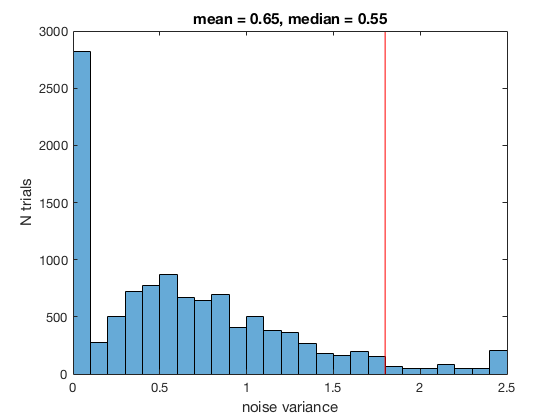

In [13]:
allnoise = [th1.noise_variance(:); th2.noise_variance(:)];
histogram(allnoise)
ylabel('N trials'); xlabel('noise variance')
title(sprintf('mean = %.2f, median = %.2f' , mean(allnoise(:)), median(allnoise(:))))
% annotate the 95% percentile
x1 = prctile(allnoise,95);
hold on;
plot([x1 x1],[0 max(ylim)], '-r');

### Show how noisy images are created
First, lets look at inamge as is with the distribution of RGB values 

In [14]:
ustims = unique(th2.presented_stim_str) % display all stimulus names used
imagename = 'chicken'; % select one for the ensuing demos


ustims =

  8×1 cell array

    'briefcase'
    'bucket'
    'cap'
    'chicken'
    'fish'
    'kiwi'
    'pear'
    'shoe'



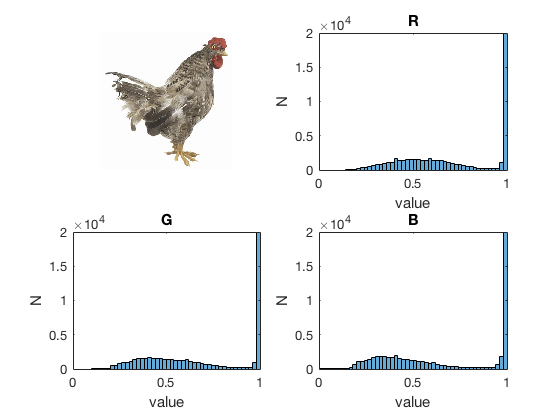

In [15]:
im = imread(['paradigm/octave/stimuli/' imagename '.jpg']);
im = double(im)./255;
subplot(2,2,1);
image(uint8(im.*255));
set(gca,'PlotBoxAspectRatio',[1 1 1]);
axis off
rgblabel = {'R', 'G', 'B'};
for i = 1:3 
    subplot(2,2,1+i);
    histogram(im(:,:,i));
    ylim([0 20000]) % lets truncate here because there are a lot of pixesl with RGB of [1 1 1], i.e., white
    xlabel('value')
    ylabel('N')
    title(rgblabel{i})
end

For the sake of brevity, we collape RGB hisgograms into one:

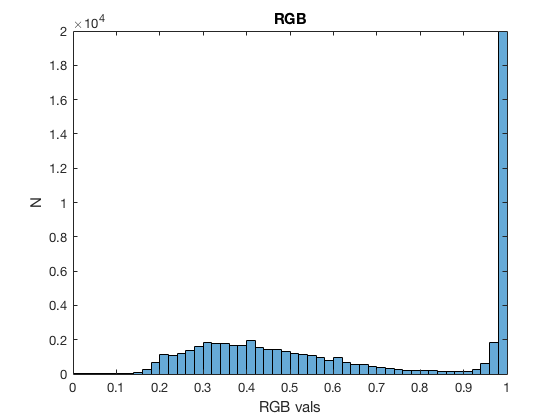

In [16]:
histogram(im(:,:,i));
ylim([0 20000]) % lets truncate here because there are a lot of pixesl with RGB of [1 1 1], i.e., white
xlabel('RGB vals')
ylabel('N')
title('RGB')

Lookup the noise variance values for the bucket at the << th and and @th in the post threshold test

In [17]:
wellbelowidx = strcmp(th2.presented_stim_str, imagename) & th2.th == 0;
atthidx = strcmp(th2.presented_stim_str, imagename) & th2.th == 1;
atth = th2.noise_variance(atthidx);
wellbelowth = th2.noise_variance(wellbelowidx);

matth = mean(atth(:));
mwellbelwoth = mean(wellbelowth(:));
disp(sprintf('intenstity of %s @th = %.3f, <<th = %.3f', imagename, matth, mwellbelwoth))

intenstity of chicken @th = 0.292, <<th = 0.585


add some noise to the image and look at it again

noise (`variance`) was varied from 0 (>th) and maximally to 2.5 in the experiment. 

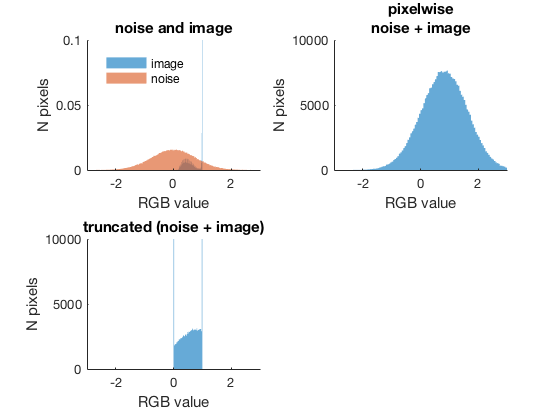

In [18]:
% change this variable here to add more or less noise:
% variance = mwellbelwoth;
variance = 0.585; % see above
mu = 0; % this variable was always zero

% the noise distribution was done as follows
noisedist = sqrt(variance)*randn(size(im)) + mu;

fh = figure;
subplot(2,2,1);
hd(1) = histogram(im, 'EdgeColor', 'none', 'Normalization', 'probability');

hold on;
hd(2) = histogram(noisedist, 'EdgeColor', 'none', 'Normalization', 'probability');

ylim([0 0.1]);
xlim([-3 3]);
box off;
title('noise and image');
legend(hd, {'image', 'noise'}, 'Location', 'NorthWest', 'box', 'off')
xlabel('RGB value')
ylabel('N pixels')

subplot(2,2,2);
output_image1 = im + noisedist; 
hd(1) = histogram(output_image1, 'EdgeColor', 'none');
ylim([0 10000]);
xlim([-3 3]);
title({'pixelwise', 'noise + image'});
box off;
xlabel('RGB value')
ylabel('N pixels')

subplot(2,2,3)
output_image2 = max(0,min(output_image1,1));
hd(2) = histogram(output_image2, 'EdgeColor', 'none');
ylim([0 10000]);
xlim([-3 3]);
title('truncated (noise + image)');
box off;
xlabel('RGB value')
ylabel('N pixels')

%subplot(2,2,4)
%image(uint8(output_image2.*255));
%set(gca,'PlotBoxAspectRatio',[1 1 1]);
%title('resulting image');
%axis off

Now we would like to look at the picture in the resolution that was actually used in the experiment. Unlike in standalone matlab, we need to set figure size and resolution using `PaperUnits` and `PaperPosition` Properties to achieve this.

Starting in R2015b, distances in pixels are independent of your system resolution on Windows and Macintosh systems:
- On Windows, a pixel is 1/96th of an inch.
- On Mac, a pixel is 1/72nd of an inch.
- On Linux, the size of a pixel is determined by system resolution.

As we cannot use `pixels` as units for `PaperPosition` we resort to using `Points`. One point equals 1/72nd of an inch. On a mac a pixel should then be the same as a point but at least on my system, this was not the case - specyfing `PaperPosition = [0 0 320 320]` resulted in a png file of size 640$\times$640 pixels. To account for this, we added a `MagicNumber = 0.5` with which `PaperPosition` is multiplied.

noise variance: 0.58


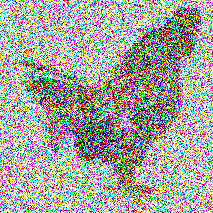

In [19]:
magicNumber = 0.5; % change this on your system such that the resulting image has resolution of 320x320 pixels.
fig = gcf;
fig.PaperUnits = 'points';
fig.PaperPosition = [0 0 320 320] .* magicNumber;

image(uint8(output_image2.*255));
axpos = set(gca, 'Position', [0 0 1 1]);
axis off
print([outputdir filesep 'noisydemo'],'-dpng','-r0')
disp(sprintf('noise variance: %.2f', variance))